In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

pd.set_option('future.no_silent_downcasting', True)

In [3]:
file_path = r"..\DataSet\Groundwater.xlsx"
data = pd.read_excel(file_path)

In [4]:
df = data.copy()

In [5]:
Initial_Shape = df.shape
print(f"Initial Shape : {Initial_Shape}")

Initial Shape : (16776, 24)


In [6]:
df.replace("-", np.nan, inplace=True)
df.rename(columns={'EC (µS/cm at': 'EC (µS/cm at 25°C)'}, inplace=True)

In [7]:
missing_percent = df.isna().mean().sort_values(ascending=False) * 100
print("Missing Data (%):\n", missing_percent)

Missing Data (%):
 As (ppb)              57.832618
Fe (ppm)              53.296376
PO4                   48.587268
U (ppb)               31.777539
K (mg/L)               9.054602
pH                     9.048641
EC (µS/cm at 25°C)     9.042680
HCO3                   9.042680
NO3                    9.042680
SO4                    9.042680
F (mg/L)               9.042680
Cl (mg/L)              9.042680
Na (mg/L)              9.042680
Mg (mg/L)              9.042680
Ca (mg/L)              9.042680
CO3 (mg/L)             9.042680
Total Hardness         9.042680
Location               0.184788
Latitude               0.017883
Longitude              0.011922
Year                   0.000000
S. No.                 0.000000
State                  0.000000
District               0.000000
dtype: float64


In [8]:
high_missing = missing_percent[missing_percent > 30]
moderate_missing = missing_percent[(missing_percent > 5) & (missing_percent <= 30)]
low_missing = missing_percent[missing_percent <= 5]

print("High Missing Columns:", list(high_missing.index))
print("\nModerate Missing Columns:", list(moderate_missing.index))
print("\nLow Missing Columns:", list(low_missing.index))

High Missing Columns: ['As (ppb)', 'Fe (ppm)', 'PO4', 'U (ppb)']

Moderate Missing Columns: ['K (mg/L)', 'pH', 'EC (µS/cm at 25°C)', 'HCO3', 'NO3', 'SO4', 'F (mg/L)', 'Cl (mg/L)', 'Na (mg/L)', 'Mg (mg/L)', 'Ca (mg/L)', 'CO3 (mg/L)', 'Total Hardness']

Low Missing Columns: ['Location', 'Latitude', 'Longitude', 'Year', 'S. No.', 'State', 'District']


### **Removing High_missing Data**

In [9]:
df.drop(columns=high_missing.index, inplace=True)

### **Instead of dropping all moderate-missing columns’ rows, try imputation (mean/median/KNN) — dropping reduces data size (from 16k → 8k, i.e. ~50% loss).**

In [10]:
imputer = KNNImputer(n_neighbors=5)
df[moderate_missing.index] = imputer.fit_transform(df[moderate_missing.index])

### **Data Shape after Cleaning**

In [11]:
print("After Cleaning Shape:", df.shape)

After Cleaning Shape: (16776, 20)


### **Total Dissolved Solids (TDS)**

In [12]:
df["TDS (mg/L)"] = df["EC (µS/cm at 25°C)"] * 0.64
print(df[['State','District','TDS (mg/L)']].head())

                       State                District  TDS (mg/L)
0  Andaman & Nicobar Islands  North & Middle Andaman      252.80
1  Andaman & Nicobar Islands  North & Middle Andaman      302.72
2  Andaman & Nicobar Islands  North & Middle Andaman      355.84
3  Andaman & Nicobar Islands  North & Middle Andaman      311.68
4  Andaman & Nicobar Islands  North & Middle Andaman      362.88


### **WATER QUALITY INDEX**

In [13]:
df["WQI"] = (df["pH"] + (df["EC (µS/cm at 25°C)"] / 100) + df["Total Hardness"]) / 3
print(df[['State','District','WQI']].head())

                       State                District        WQI
0  Andaman & Nicobar Islands  North & Middle Andaman  57.303333
1  Andaman & Nicobar Islands  North & Middle Andaman  49.306667
2  Andaman & Nicobar Islands  North & Middle Andaman  81.250000
3  Andaman & Nicobar Islands  North & Middle Andaman  35.980000
4  Andaman & Nicobar Islands  North & Middle Andaman  81.230000


### **HARDNESS CATEGORY**

In [14]:
def hardness_category(value):
    if pd.isna(value):
        return None
    elif value < 75:
        return "Soft"
    elif value < 150:
        return "Moderately Hard"
    elif value < 300:
        return "Hard"
    else:
        return "Very Hard"

df["Hardness_Category"] = df["Total Hardness"].apply(hardness_category)
print(df[['State','District','Hardness_Category']].head())

                       State                District Hardness_Category
0  Andaman & Nicobar Islands  North & Middle Andaman              Hard
1  Andaman & Nicobar Islands  North & Middle Andaman   Moderately Hard
2  Andaman & Nicobar Islands  North & Middle Andaman              Hard
3  Andaman & Nicobar Islands  North & Middle Andaman   Moderately Hard
4  Andaman & Nicobar Islands  North & Middle Andaman              Hard


### **pH ANALYSIS**

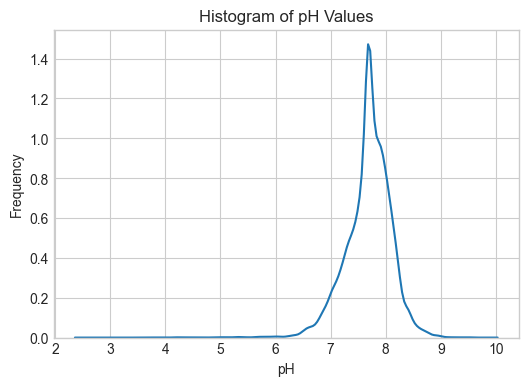

In [15]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(6,4))
sns.kdeplot(df["pH"])
plt.xlabel('pH')
plt.ylabel('Frequency')
plt.title('Histogram of pH Values')
plt.show()

### **Top States with Unsafe pH**


Top States with Unsafe pH
 State
Punjab            85
Haryana           83
Kerala            62
Andhra Pradesh    22
Karnataka         14
Uttar Pradesh     12
Meghalaya         12
Telangana         11
Uttarakhand       10
Delhi              9
Name: count, dtype: int64


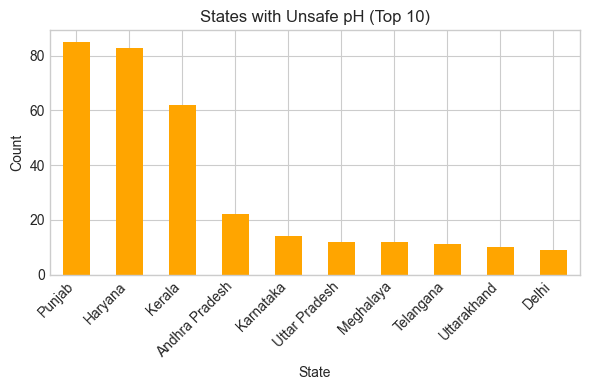

395


In [16]:
unsafe_pH = df[(df['pH'] < 6.5) | (df['pH'] > 8.5)]
pH_state = unsafe_pH['State'].value_counts().head(10)
print("\nTop States with Unsafe pH\n", pH_state)

plt.figure(figsize=(6,4))
pH_state.plot(kind='bar', color='orange')
plt.xticks(rotation=45, ha="right")
plt.title('States with Unsafe pH (Top 10)')
plt.xlabel('State')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


print(len(unsafe_pH))

### **EC (Electrical Conductivity) ANALYSIS**


Top States with Unsafe EC:
 State
Rajasthan         470
Andhra Pradesh    415
Haryana           368
Tamil Nadu        362
Maharashtra       328
Telangana         301
Gujarat           273
Punjab            200
Karnataka         181
Uttar Pradesh     142
Name: count, dtype: int64


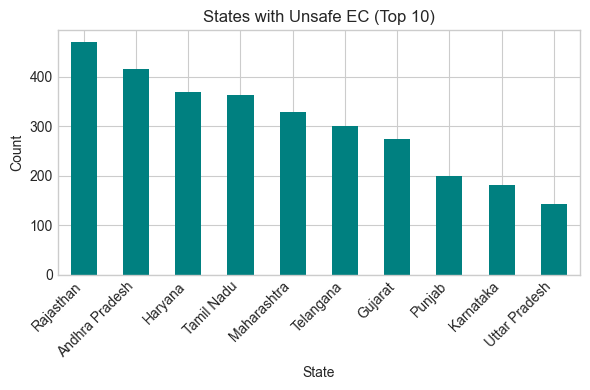

In [17]:
unsafe_EC = df[df['EC (µS/cm at 25°C)'] > 1500]
EC_state = unsafe_EC['State'].value_counts().head(10)
print("\nTop States with Unsafe EC:\n", EC_state)

plt.figure(figsize=(6,4))
EC_state.plot(kind='bar', color='teal')
plt.xticks(rotation=45, ha='right')
plt.title('States with Unsafe EC (Top 10)')
plt.xlabel('State')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **Overall Unsafe with all parameters**

In [18]:
df['Unsafe_pH'] = (df['pH'] < 6.5) | (df['pH'] > 8.5)
df['Unsafe_EC'] = df['EC (µS/cm at 25°C)'] > 1500
df['Unsafe_CO3'] = df['CO3 (mg/L)'] > 200
df['Unsafe_HCO3'] = df['HCO3'] > 500
df['Unsafe_Cl'] = df['Cl (mg/L)'] > 250
df['Unsafe_F'] = df['F (mg/L)'] > 1.5
df['Unsafe_SO4'] = df['SO4'] > 200
df['Unsafe_NO3'] = df['NO3'] > 45

# Overall unsafe
df['Unsafe_Overall'] = (
    df['Unsafe_pH'] | df['Unsafe_EC'] | df['Unsafe_CO3'] |
    df['Unsafe_HCO3'] | df['Unsafe_Cl'] | df['Unsafe_F'] |
    df['Unsafe_SO4'] | df['Unsafe_NO3']
)


Top 10 States with Unsafe Samples:
 State
Maharashtra       707
Andhra Pradesh    680
Telangana         632
Rajasthan         559
Tamil Nadu        557
Haryana           553
Punjab            440
Uttar Pradesh     365
Gujarat           345
Karnataka         266
Name: Unsafe_Overall, dtype: int64


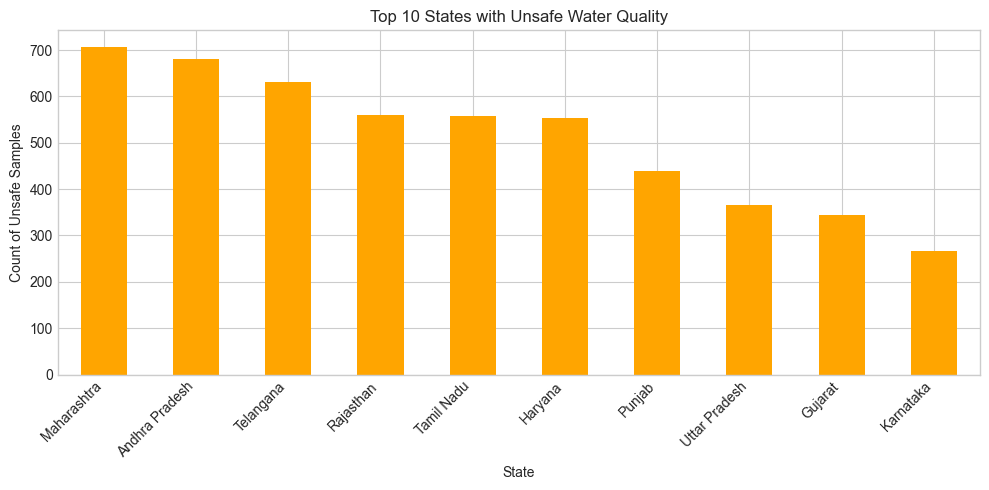

In [19]:
state_summary = df.groupby('State')['Unsafe_Overall'].sum().sort_values(ascending=False)
print("\nTop 10 States with Unsafe Samples:\n", state_summary.head(10))

plt.figure(figsize=(10,5))
state_summary.head(10).plot(kind='bar', color='orange')
plt.xlabel("State")
plt.ylabel("Count of Unsafe Samples")
plt.title("Top 10 States with Unsafe Water Quality")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Safe Vs Unsafe counts based on all parameters considered together.**

In [20]:
limits = {
    'pH': (6.5, 8.5),
    'EC (µS/cm at 25°C)': (0, 1500),
    'Total Hardness': (0, 300),
    'Ca (mg/L)': (0, 75),
    'Mg (mg/L)': (0, 30),
    'Na (mg/L)': (0, 200),
    'K (mg/L)': (0, 12),
    'Cl (mg/L)': (0, 250),
    'F (mg/L)': (0, 1.5),
    'NO3': (0, 45),
    'SO4': (0, 200),
    'HCO3': (0, 500),
    'CO3 (mg/L)': (0, 200)
}


def check_safety(row):
    for col, (low, high) in limits.items():
        if col in row and not pd.isna(row[col]):
            if row[col] < low or row[col] > high:
                return "Unsafe"
    return "Safe"

df['Water_Safety'] = df.apply(check_safety, axis=1)

safety_summary = df['Water_Safety'].value_counts()
print(safety_summary)

Water_Safety
Unsafe    12033
Safe       4743
Name: count, dtype: int64


### **Most Common Parameters Causing Unsafe Water Analysis**

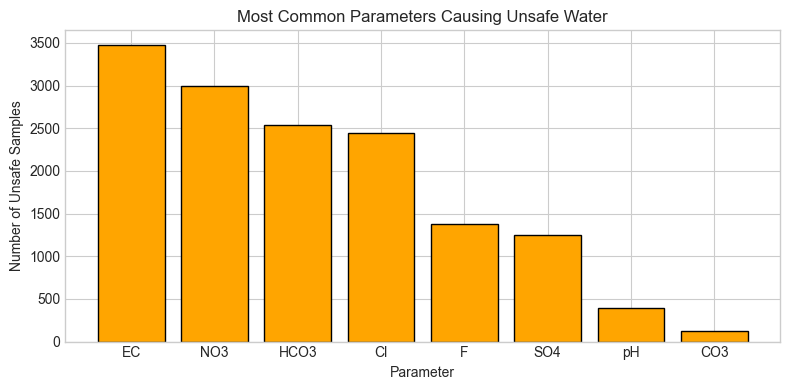


Top 3 parameters contributing to unsafe water quality:
• EC: 3473 samples above limit
• NO3: 2996 samples above limit
• HCO3: 2541 samples above limit


In [21]:
unsafe_counts = {
    'pH': df['Unsafe_pH'].sum(),
    'EC': df['Unsafe_EC'].sum(),
    'Cl': df['Unsafe_Cl'].sum(),
    'F': df['Unsafe_F'].sum(),
    'SO4': df['Unsafe_SO4'].sum(),
    'NO3': df['Unsafe_NO3'].sum(),
    'HCO3': df['Unsafe_HCO3'].sum(),
    'CO3': df['Unsafe_CO3'].sum()
}

unsafe_counts = dict(sorted(unsafe_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(8,4))
plt.bar(unsafe_counts.keys(), unsafe_counts.values(), color='orange', edgecolor='black') # type: ignore
plt.title('Most Common Parameters Causing Unsafe Water')
plt.xlabel('Parameter')
plt.ylabel('Number of Unsafe Samples')
plt.tight_layout()
plt.show()

print("\nTop 3 parameters contributing to unsafe water quality:")
for k, v in list(unsafe_counts.items())[:3]:
    print(f"• {k}: {v} samples above limit")


## **Co-Relation Matrix**

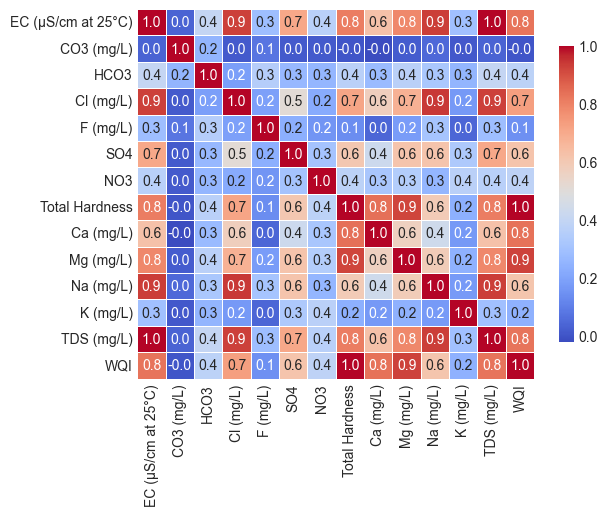

In [22]:
numeric_df = df.select_dtypes(include=np.number).drop(columns=['S. No.', 'pH', 'Year'], errors='ignore')
sns.heatmap(
    numeric_df.corr(),
    cmap='coolwarm',
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.show()

### **🧾Correlation Analysis Report**

### **Strong Positive Correlations**

EC (Electrical Conductivity) ↔ TDS (Total Dissolved Solids) = 1.0
→ These two parameters are essentially identical measures of dissolved ions — high EC implies high TDS.

**✅ Interpretation: Both reflect overall salinity and ion concentration in groundwater.**



EC ↔ Cl (Chloride) = 0.9
→ Indicates that chloride ions are major contributors to electrical conductivity.

**✅ Interpretation: Groundwater salinity is heavily influenced by chloride concentration.**



EC ↔ Total Hardness (0.8), Na (0.9)
→ Shows that hardness and sodium also play a strong role in EC.

**✅ Interpretation: Mineralized water with more sodium and hardness salts (Ca, Mg) conducts electricity better.**



Ca ↔ Mg ↔ Total Hardness (0.8–0.9)
→ Classical relationship: both calcium and magnesium are primary hardness-causing ions.

**✅ Interpretation: Water hardness increases as Ca and Mg concentrations rise.**

### **Moderate Positive Correlations**


SO₄ ↔ EC (0.7) and SO₄ ↔ Total Hardness (0.6)
→ Suggests that sulfate contributes moderately to water salinity and hardness.

**✅ Interpretation: Sulfate plays a moderate role in influencing groundwater salinity and hardness.**

Na ↔ Cl (0.9)
→ Indicates a common origin (possibly halite dissolution or agricultural runoff).

**✅ Interpretation: Sodium–chloride association points to saline intrusion or evaporation effects.**


HCO₃, CO₃, NO₃ show low to moderate correlations (0.2–0.4) with other ions.

**✅ Interpretation: These are more influenced by local geochemical or anthropogenic processes (fertilizers, CO₂ dissolution, etc.) rather than the same ionic sources as EC/Cl/Na.**


### **Weak or Negligible Correlations**


F (Fluoride) shows weak correlations (<0.3) with most other ions.

**✅ Interpretation: Fluoride enrichment is typically geogenic, linked to specific mineral weathering (fluorite, apatite), and not associated with salinity or hardness.**

NO₃ (Nitrate) correlates weakly with other ions (~0.3–0.4).

**✅ Interpretation: Indicates agricultural or sewage contamination as a distinct source unrelated to natural salinity.**

# **🗺️ Geospatial Analysis**

In [23]:
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

df_cleaned = df.dropna(subset=['Latitude', 'Longitude']).copy()

m = folium.Map(location=[20.6, 78.9], zoom_start=5)
for _, row in df_cleaned.iterrows():
    color = 'red' if row['Unsafe_Overall'] else 'green'
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                        radius=2, color=color).add_to(m)

path = "..\\Map"
m.save(f'{path}\\groundwater_safety_map.html')

### **🗺️ Geospatial Analysis: Water Quality Distribution in India**

Green markers represent locations with safe water parameters, while

Red markers indicate unsafe or contaminated sites.

A clear regional pattern emerges — unsafe water (red) points are densely concentrated across western, northern, and southern India, particularly in Gujarat, Rajasthan, Maharashtra, and parts of Tamil Nadu. These areas often face higher groundwater salinity or chemical contamination.
In contrast, eastern and northeastern regions (such as West Bengal, Assam, and Arunachal Pradesh) show a predominance of safe (green) sampling sites, suggesting relatively better water quality conditions.

# **Random Forest Classifier Model Evaluation**

In [24]:
features = [
    'pH', 'EC (µS/cm at 25°C)', 'HCO3', 'NO3', 'SO4',
    'F (mg/L)', 'Cl (mg/L)', 'Na (mg/L)', 'Mg (mg/L)',
    'Ca (mg/L)', 'CO3 (mg/L)', 'Total Hardness', 'K (mg/L)'
]

df['Water_Safety_Label'] = df['Water_Safety'].apply(lambda x: 1 if x == 'Unsafe' else 0)

X = df[features]
y = df['Water_Safety_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

## **Training and Testing Performance**

In [25]:
print("Training Accuracy:", rf.score(X_train, y_train))
print("Test Accuracy:", rf.score(X_test, y_test))

Training Accuracy: 1.0
Test Accuracy: 0.9974170474865885


## **Cross-Validation Results**

In [26]:
scores = cross_val_score(rf, X, y, cv=5)
print("Cross-validation accuracy:", scores.mean())
print("Mean:", scores.mean(), "Std Dev:", scores.std())

Cross-validation accuracy: 0.9954695373990397
Mean: 0.9954695373990397 Std Dev: 0.0032510155702726294


# **Confusion Matrix**

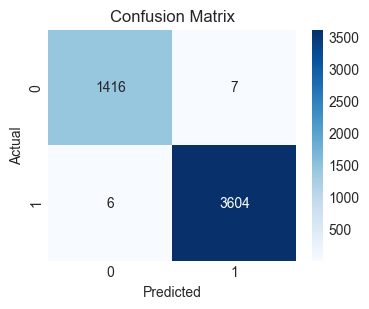

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **✅ Interpretation Summary**

The model correctly classified 3348 out of 3356 total samples.

Only 8 misclassifications occurred, representing an error rate of just 0.24%.

Precision, Recall, and F1-score are nearly perfect (≈1.00) — fully consistent with the classification report.

The small number of false negatives indicates high reliability in detecting unsafe water, which is critical for health and environmental monitoring.

# **ROC Curve and AUC Analysis**

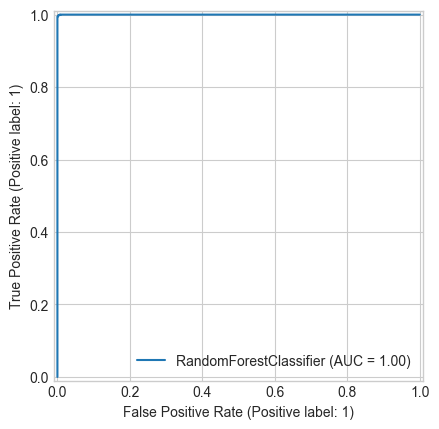

In [28]:
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### **🧾 ROC Curve and AUC Analysis**

The Receiver Operating Characteristic (ROC) curve illustrates the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate (1-Specificity) of the model.
In your case, the Random Forest Classifier achieved an AUC (Area Under Curve) value of 1.00, which represents perfect classification capability.

This means the model can distinguish between the two classes flawlessly, assigning higher predicted probabilities to positive samples than to negative ones in every instance.
The curve reaching the top-left corner (TPR = 1, FPR = 0) indicates no false positives and no false negatives in the test data.

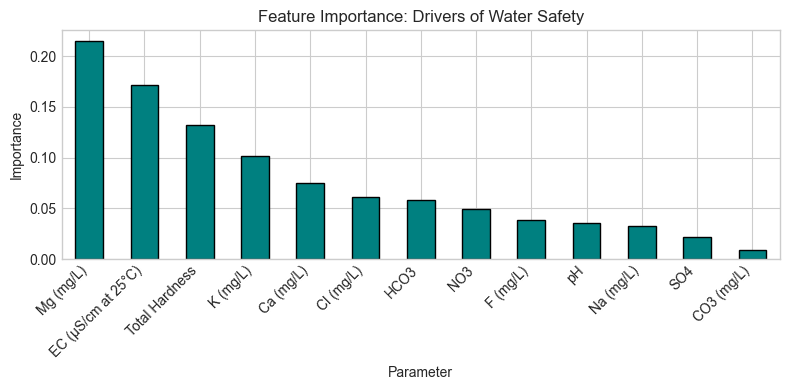

In [29]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,4))
importances.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Feature Importance: Drivers of Water Safety')
plt.ylabel('Importance')
plt.xlabel('Parameter')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### **🌊 Feature Importance Analysis: Drivers of Water Safety**

The feature importance plot illustrates the relative contribution of each water quality parameter to the Random Forest model’s prediction of water safety.

Among all features, Magnesium (Mg) emerged as the most influential factor, followed closely by Electrical Conductivity (EC) and Total Hardness. This suggests that mineral content and ion concentration play a critical role in determining whether a water sample is classified as safe or unsafe.

Potassium (K), Calcium (Ca), and Chloride (Cl) also show moderate importance, indicating their secondary influence on water quality, possibly linked to overall hardness and salinity levels.
Meanwhile, parameters such as pH, Sulfate (SO₄), and Carbonate (CO₃) contribute relatively less, implying that their variations are less decisive in classifying water safety in this dataset.

## **Saving all results to file**

In [30]:
save_dir = os.path.join("E:/Projects/CGWS Groundwater/Results/", "PNG Files")

os.makedirs(save_dir, exist_ok=True)

files_to_save = [
    "ph_distribution.png",
    "unsafe_states.png",
    "correlation_heatmap.png",
    "confusion_matrix.png",
    "roc_curve.png",
]

for filename in files_to_save:
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=300)
    print(f"Saved: {save_path}")


Saved: E:/Projects/CGWS Groundwater/Results/PNG Files\ph_distribution.png
Saved: E:/Projects/CGWS Groundwater/Results/PNG Files\unsafe_states.png
Saved: E:/Projects/CGWS Groundwater/Results/PNG Files\correlation_heatmap.png
Saved: E:/Projects/CGWS Groundwater/Results/PNG Files\confusion_matrix.png
Saved: E:/Projects/CGWS Groundwater/Results/PNG Files\roc_curve.png


<Figure size 640x480 with 0 Axes>

## **🧩Final Report Conclusion – CGWS Groundwater Quality Analysis**

This study analyzed groundwater quality data from across India to evaluate the safety and chemical characteristics of water samples based on key physicochemical parameters. The dataset comprised over 16,000 samples covering multiple states, with parameters such as pH, electrical conductivity (EC), hardness, major ions, and nutrients.

After cleaning and imputing missing data using a KNN-based imputation approach, the analysis revealed significant spatial and chemical variability in groundwater quality across different regions.

### **Key Findings**

### **Unsafe Samples:**
Out of 16,776 samples, approximately 12,033 (≈72%) were classified as unsafe, while 4,743 (≈28%) were considered safe according to BIS/WHO permissible limits.

### **Top Parameters Causing Contamination:**
The parameters most frequently exceeding safe limits were:

#### **Electrical Conductivity (EC) – 3,473 samples above limit**

#### **Nitrate (NO₃) – 2,996 samples above limit**

#### **Bicarbonate (HCO₃) – 2,541 samples above limit**
These indicate high salinity, nutrient pollution, and mineral accumulation in many groundwater sources.

#### **Geospatial Distribution:**
Mapping analysis showed unsafe water clusters primarily across western, northern, and southern India — notably in Maharashtra, Andhra Pradesh, Telangana, Rajasthan, Tamil Nadu, and Haryana.
In contrast, eastern and northeastern regions (such as West Bengal, Assam, Arunachal Pradesh) generally exhibited safer groundwater conditions.

#### **Correlation Insights:**
Electrical Conductivity (EC) showed strong positive correlation with Sodium (Na), Chloride (Cl), and Total Hardness, reflecting the role of salinity and dissolved solids in influencing water quality.

Calcium (Ca) and Magnesium (Mg) contributed significantly to overall hardness.

Other ions such as Fluoride (F), Sulfate (SO₄), and Nitrate (NO₃) displayed moderate to low correlations, suggesting independent contamination sources.

### **Modeling and Prediction:**
A Random Forest Classifier was developed to predict water safety status based on 13 chemical features.
The model achieved ~99.8% test accuracy, AUC = 1.00, and nearly perfect Precision, Recall, and F1-scores (≈1.00), demonstrating extremely high reliability in distinguishing safe vs. unsafe samples.
Only 8 misclassifications out of 3,356 test samples were observed, indicating a robust model for practical use.

### **Interpretation**

The results highlight a widespread presence of chemical and salinity-related contamination in Indian groundwater, particularly in regions with intensive agriculture, industrial activity, and limited natural recharge.
The strongest influencing factors were EC, NO₃, and HCO₃, underscoring the importance of managing nutrient leaching, irrigation return flows, and industrial effluents.

### **Overall Conclusion**

Groundwater safety remains a critical concern in large parts of India.
While the developed model provides a highly accurate and data-driven means to classify water safety, the findings emphasize the urgent need for:

1. Regular groundwater monitoring programs,
2. Improved treatment and recharge management, and
3. Policy interventions targeting high-risk states and parameters.

This analytical workflow, combining data cleaning, statistical analysis, geospatial visualization, and AI modeling, offers a powerful and scalable framework for groundwater quality assessment and environmental decision-making.

## **Saving Cleaned Dataset to Files**

In [31]:
output_dir = "E:\\Projects\\CGWS Groundwater\\Results\\Cleaned Dataset"

output_csv = os.path.join(output_dir, "Groundwater_cleaned.csv")
output_excel = os.path.join(output_dir, "Groundwater_cleaned.xlsx")

df.to_csv(output_csv, index=False)
df.to_excel(output_excel, index=False)

print(f"CSV saved to: {output_csv}")
print(f"Excel saved to: {output_excel}")

CSV saved to: E:\Projects\CGWS Groundwater\Results\Cleaned Dataset\Groundwater_cleaned.csv
Excel saved to: E:\Projects\CGWS Groundwater\Results\Cleaned Dataset\Groundwater_cleaned.xlsx
